# Exploratory Data Analysis of Show Reviews

In this notebook I'm going to explore the reviews' dataset.

## Imports

In [1]:
import os

import pandas as pd
import torch
from tqdm.auto import tqdm

In [2]:
from shows_analysis.code.sentiment_analysis.huggingface_pipeilne import (
    InferencePipeline,
)
from shows_analysis.code.utils.plotting_utils import (
    plot_catplot,
    plot_dt_per_type,
    plot_per_type,
)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
SEED = 42

## Paths

In [5]:
RELATIVE_PATH = os.path.join("../../../", "data")
CLEANED_REVIEWS_PATH = os.path.join(RELATIVE_PATH, "2_cleaned_reviews")

## Data

### Loading data

In [6]:
reviews = pd.read_parquet(os.path.join(CLEANED_REVIEWS_PATH, "reviews.parquet"))
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206537 entries, 0 to 206536
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   show_id       206537 non-null  int64         
 1   user_id       206537 non-null  int64         
 2   type          206537 non-null  category      
 3   datetime      206537 non-null  datetime64[ns]
 4   sentiment     206537 non-null  category      
 5   subtitle      173664 non-null  object        
 6   review        206537 non-null  object        
 7   review_score  206537 non-null  int64         
 8   score         129216 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 11.4+ MB


The `subtitle` and `score` columns have null values.  
In this problem we are not going to impute them. 

### Dataset overview

In [7]:
reviews.sample(n=10, random_state=SEED)

,show_id,user_id,type,datetime,sentiment,subtitle,review,review_score,score
31211,470178,26804,movie,2019-02-16 14:28:00,positive,Обзор на фильм 'Аквамен',"Киновселенная DC, которая довольно серьезный к...",-8,10.0
72046,1950,65761,movie,2013-02-11 22:56:00,positive,Просторы другой тональности,"Не всякая карта расскажет тебе, чем богато зве...",6,9.0
12824,51319,7758,movie,2010-07-19 15:32:00,positive,"«Я была здесь лишь один момент, а потом меня н...",Этот фильм долго пылился на жестком диске и вч...,8,10.0
203242,674019,56263,series,2016-09-22 18:20:00,positive,"Между мыслью и реальностью, между движением и ...",Что могу сказать... Никогда не любила сериал п...,-4,NaN
199423,568082,33423,series,2010-11-19 15:28:00,positive,"Пацаны смотрят вдаль и верят, но трамвай не е...",О сериале 'Реальные пацаны' узнал еще летом. К...,66,9.0
125237,762738,1885,movie,2015-06-04 17:19:00,positive,"Сдох твой Бобик, Джонни!","Нюквисту – «Оскар»! (Тому самому, из шведской ...",9,NaN
165963,420923,8245,movie,2010-01-14 02:45:00,positive,И колокола в финале...,Странные я испытал эмоции при просмотре этой л...,10,10.0
61509,81314,58981,movie,2020-02-23 21:14:00,positive,"О том, как легко служит злу. и трудно - добру",В сравнение с другими гангстерскими лентами Ск...,7,NaN
132535,530,22230,movie,2012-02-27 17:39:00,positive,Всё есть число? (Амбициозная Miss Danity захот...,"А знаете, этот фильм стоит смотреть одному.<p>...",3,9.0
60474,606646,48935,movie,2014-02-23 18:31:00,positive,'Джанго' наоборот.,"Итак, для начала статистика. Данная картина бы...",0,9.0


## EDA

### General figures

In [8]:
reviews.shape[0]

206537

Overall, users left `206 737` reviews.  

In [9]:
reviews[["show_id", "user_id"]].nunique()

show_id     1862
user_id    69172
dtype: int64

The number of unique users that left reviews is `69172`. While the number of unique shows (movies/series) is `1862`.

`170 894` reviews were left for movies, which is approximately `83%`.

In [10]:
reviews["type"].value_counts()

movie     170894
series     35643
Name: type, dtype: int64

### Target

Let's look at `sentiment` by show type.

In [11]:
sentiment_by_type = (
    reviews.groupby(["type"])["sentiment"]
    .value_counts(normalize=True)
    .mul(100)
    .rename("percent")
    .reset_index()
    .rename(columns={"level_1": "sentiment"})
    .round(1)
)
sentiment_by_type

,type,sentiment,percent
0,movie,positive,72.1
1,movie,neutral,15.2
2,movie,negative,12.7
3,series,positive,71.7
4,series,negative,14.5
5,series,neutral,13.9


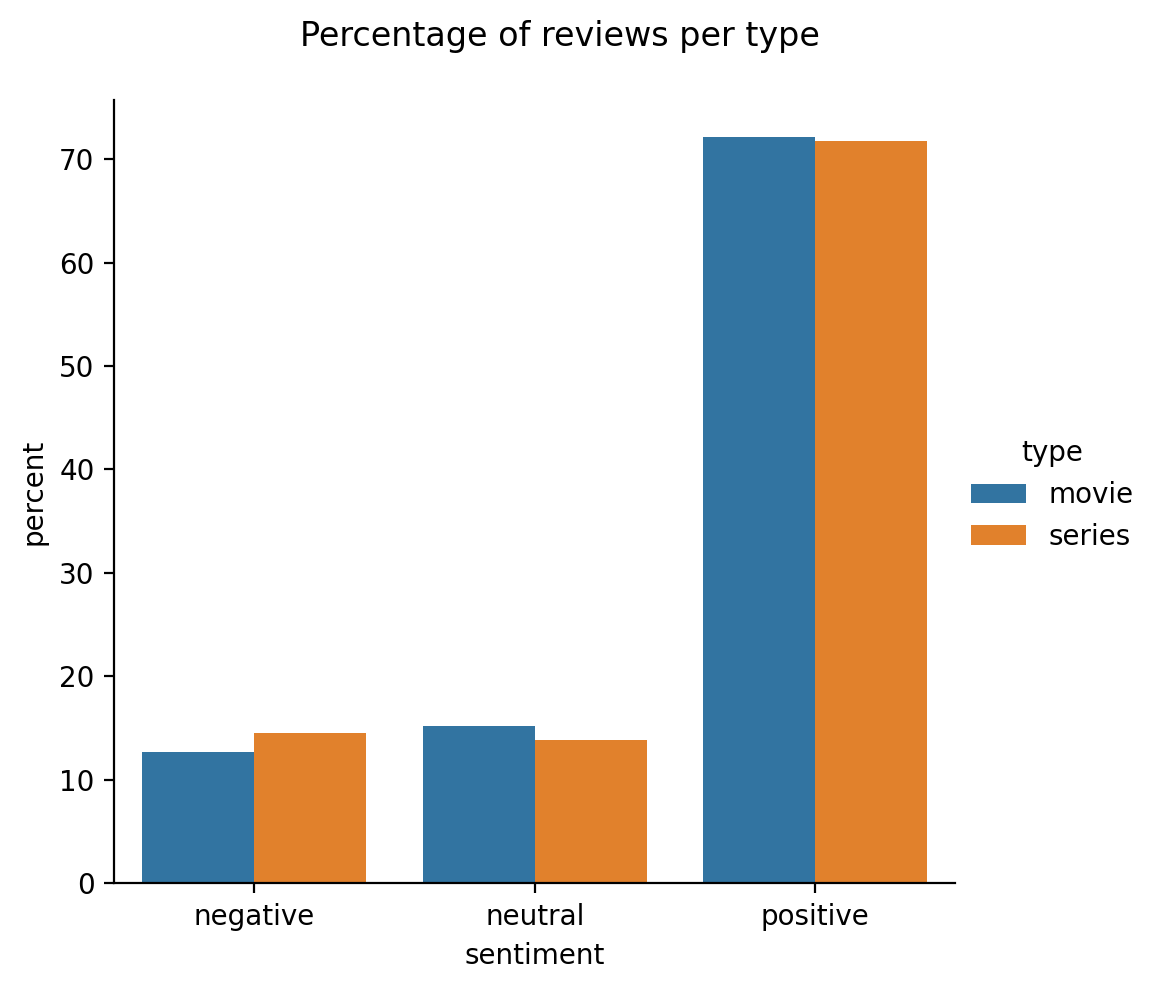

In [12]:
plot_catplot(
    y="percent",
    x="sentiment",
    hue="type",
    kind="bar",
    data=sentiment_by_type,
    medianprops={},
    title="Percentage of reviews per type",
)

We can see that the proportions roughly the same for movies and series.  
People tend to leave positive reviews (around 70%).  
The shares of neutral and negative reviews are almost the same (around 12%-15%).

### Features

#### Users

Let's look at the activity of the users

In [13]:
number_of_reviews_per_user_per_type = (
    reviews.groupby("type")
    .agg({"user_id": "value_counts"})
    .rename(columns={"user_id": "reviews_per_user"})
    .reset_index()
)

In [14]:
number_of_reviews_per_user_per_type.groupby("type")["reviews_per_user"].describe(
    percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
).round(1)

,count,mean,std,min,1%,10%,25%,50%,75%,90%,95%,99%,99.9%,max
type,,,,,,,,,,,,,,
movie,58114.0,2.9,8.7,1.0,1.0,1.0,1.0,1.0,2.0,5.0,9.0,30.0,126.9,493.0
series,20465.0,1.7,3.3,1.0,1.0,1.0,1.0,1.0,2.0,3.0,4.0,12.0,38.5,150.0


As we can see, on average, users leave 3 reviews, but the median value is equal to 1 review.  
It means that we have a lot of outliers - people, who leave enormous amounts of reviews.

In [15]:
number_of_reviews_per_user_per_type_cut = number_of_reviews_per_user_per_type[
    number_of_reviews_per_user_per_type["reviews_per_user"] <= 9
]

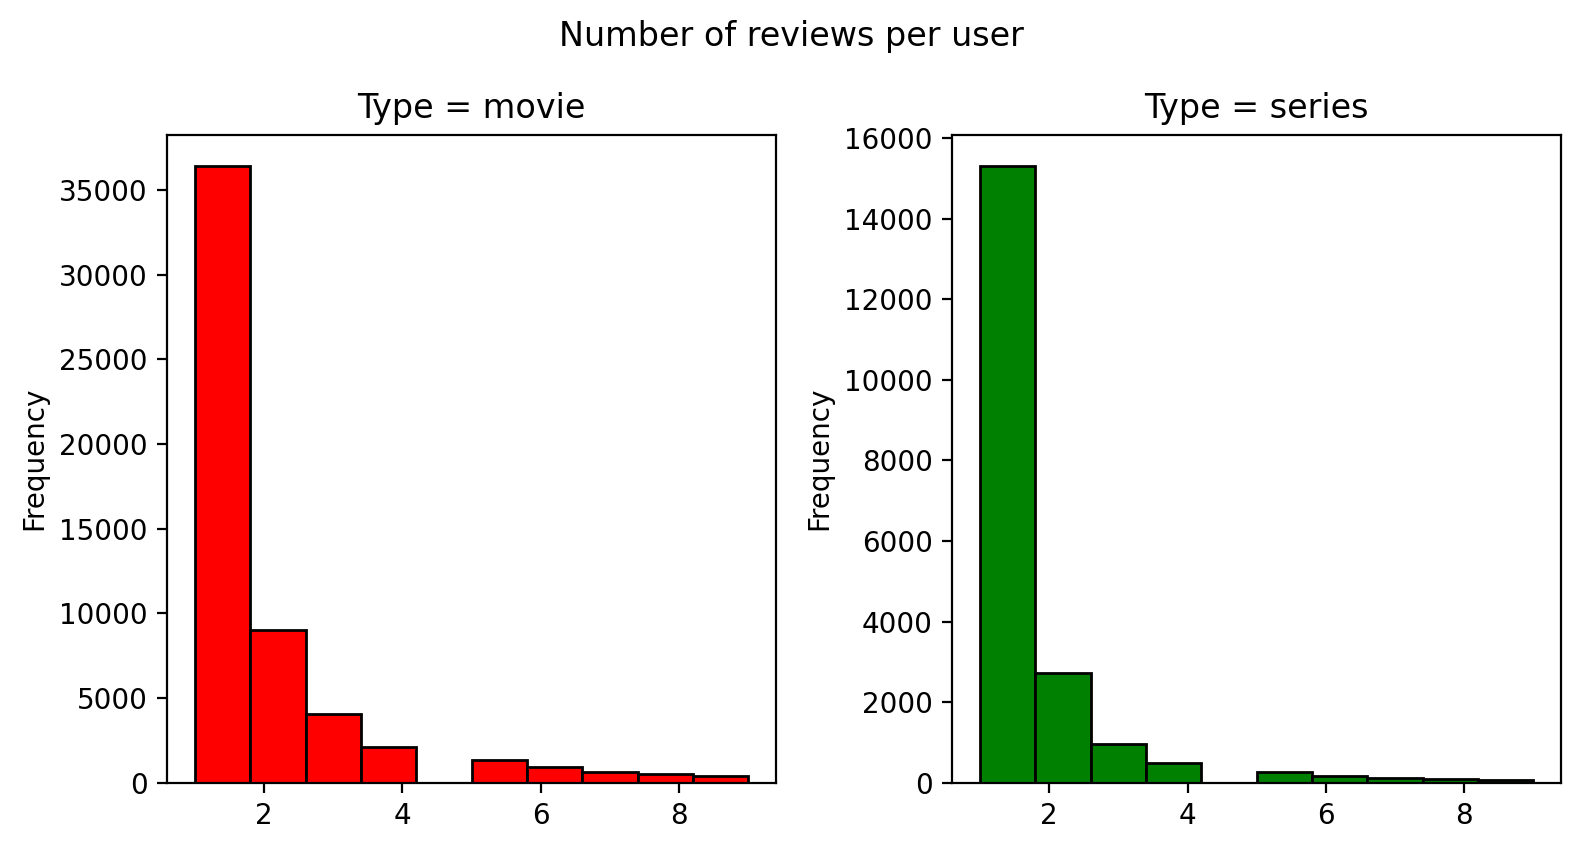

In [16]:
plot_per_type(
    dataframe=number_of_reviews_per_user_per_type_cut,
    column="reviews_per_user",
    title="Number of reviews per user",
    title_shift=1.05,
)

We can see that most of the users leave from 1 to 4 reviews and the distribution of reviews does not differ for movies and series.

#### Reviews

Let's analyze the popularity of the shows.

In [17]:
number_of_reviews_per_user_per_type = (
    reviews.groupby("type")
    .agg({"show_id": "value_counts"})
    .rename(columns={"show_id": "reviews_per_show"})
    .reset_index()
)

In [18]:
number_of_reviews_per_user_per_type.groupby("type")["reviews_per_show"].describe(
    percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
).round(1)

,count,mean,std,min,1%,10%,25%,50%,75%,90%,95%,99%,99.9%,max
type,,,,,,,,,,,,,,
movie,947.0,180.5,210.2,1.0,1.0,7.0,35.0,123.0,253.0,400.0,578.4,945.6,1771.5,2200.0
series,915.0,39.0,69.9,1.0,1.0,3.0,6.0,16.0,43.0,87.6,137.6,378.4,658.3,715.0


On average, people leave approximately 181 reviews per movie and 39 reviews per series.

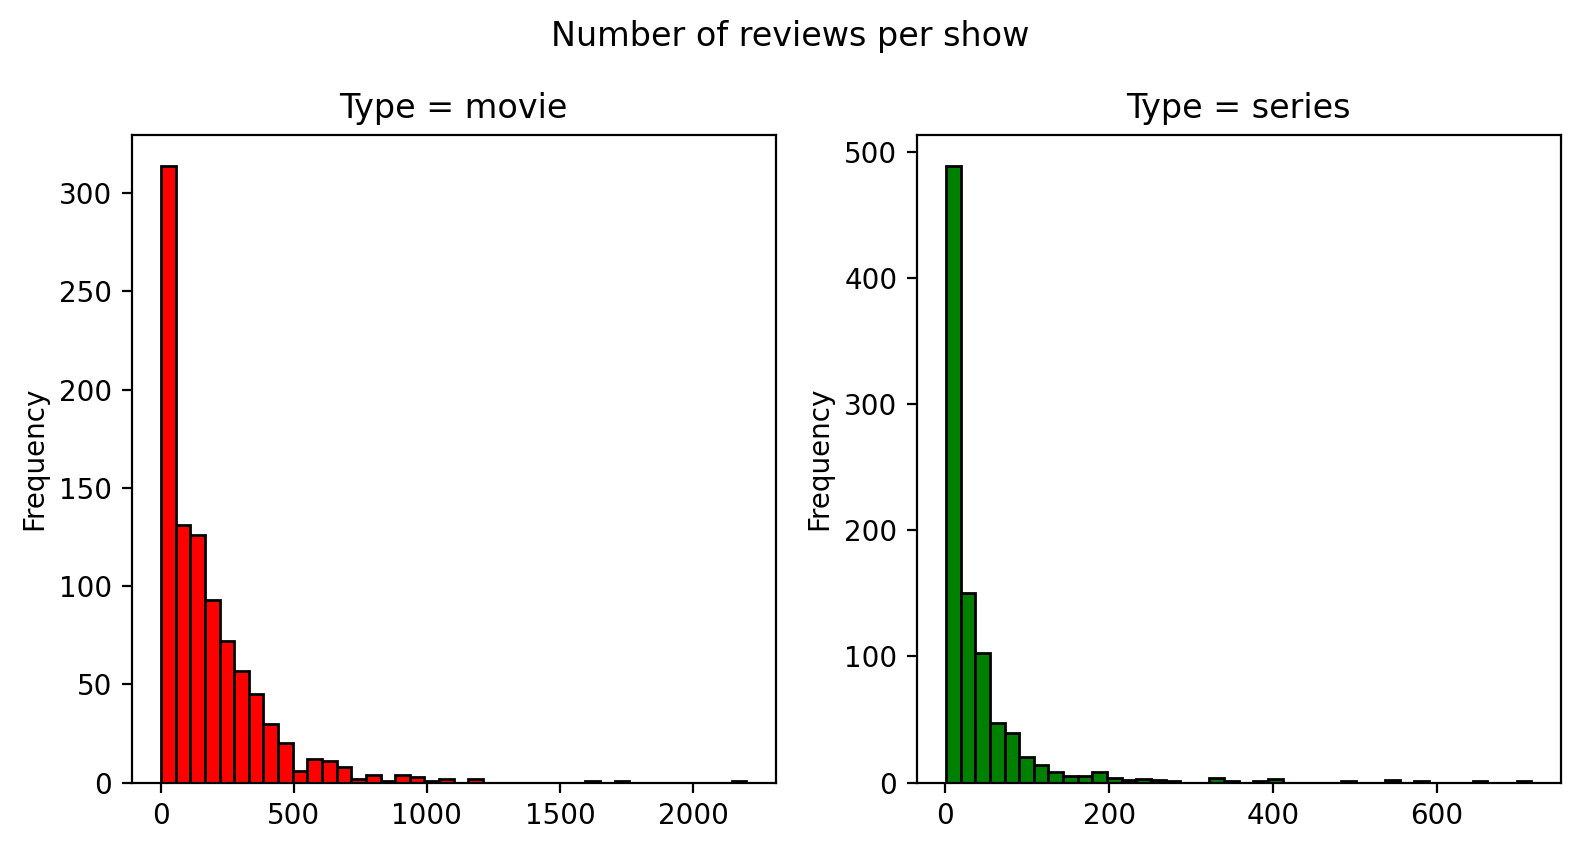

In [19]:
plot_per_type(
    dataframe=number_of_reviews_per_user_per_type,
    column="reviews_per_show",
    title="Number of reviews per show",
    bins=40,
    title_shift=1.05,
)

Here we see expected pattern - there are few movies, which have a lot of reviews.

#### Date and time of review

In [20]:
reviews["hour"] = reviews["datetime"].dt.hour
reviews["weekday"] = reviews["datetime"].dt.weekday
reviews["month"] = reviews["datetime"].dt.month - 1

##### Hour distribution

Let's look at hour distribution

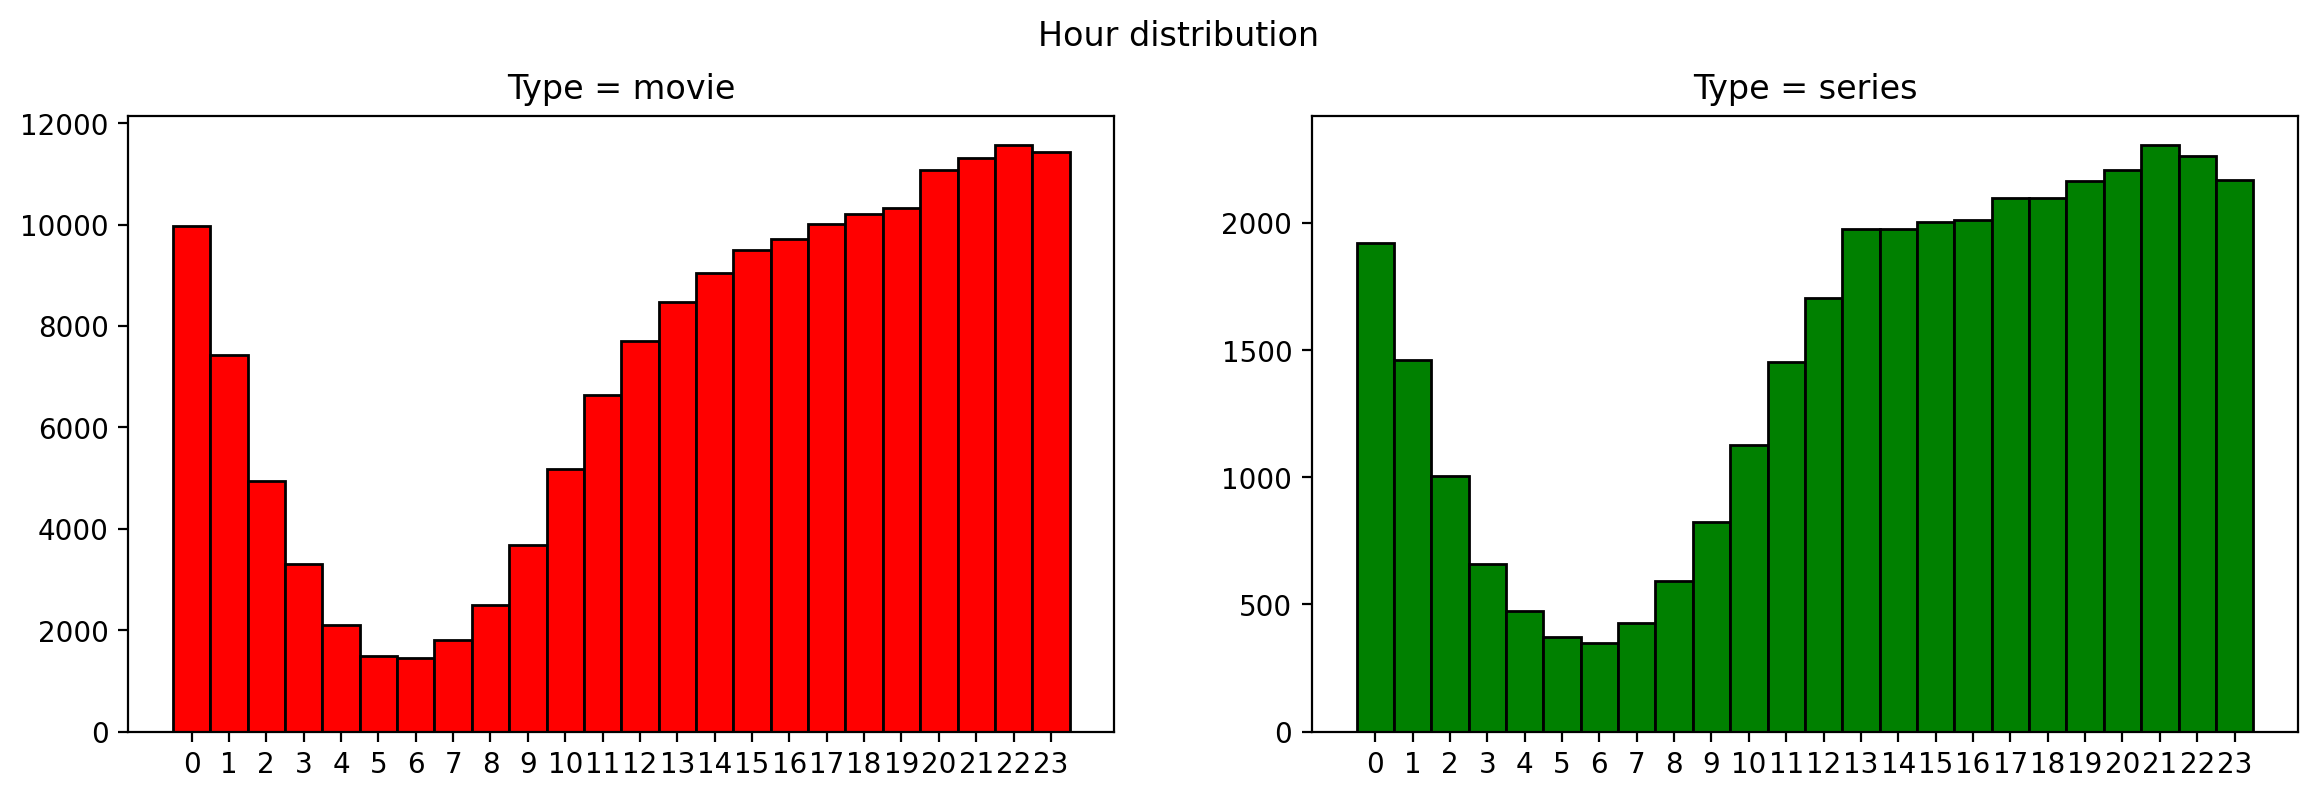

In [21]:
plot_dt_per_type(
    dataframe=reviews, column="hour", title="Hour distribution", title_shift=1.0
)

People tend to publish reviews closer to the night with absolute maximum around 20-23 o'clock and absolute minimum around 4-7 o'clock.  
Although, I'm not sure whether timezone was taken into account (all data is +3 UTC) or these dates and times are distributed along 11 time zones.  

Let's think that we have dates and times, which were actual for the people when they left their reviews.

##### Weekday distribution

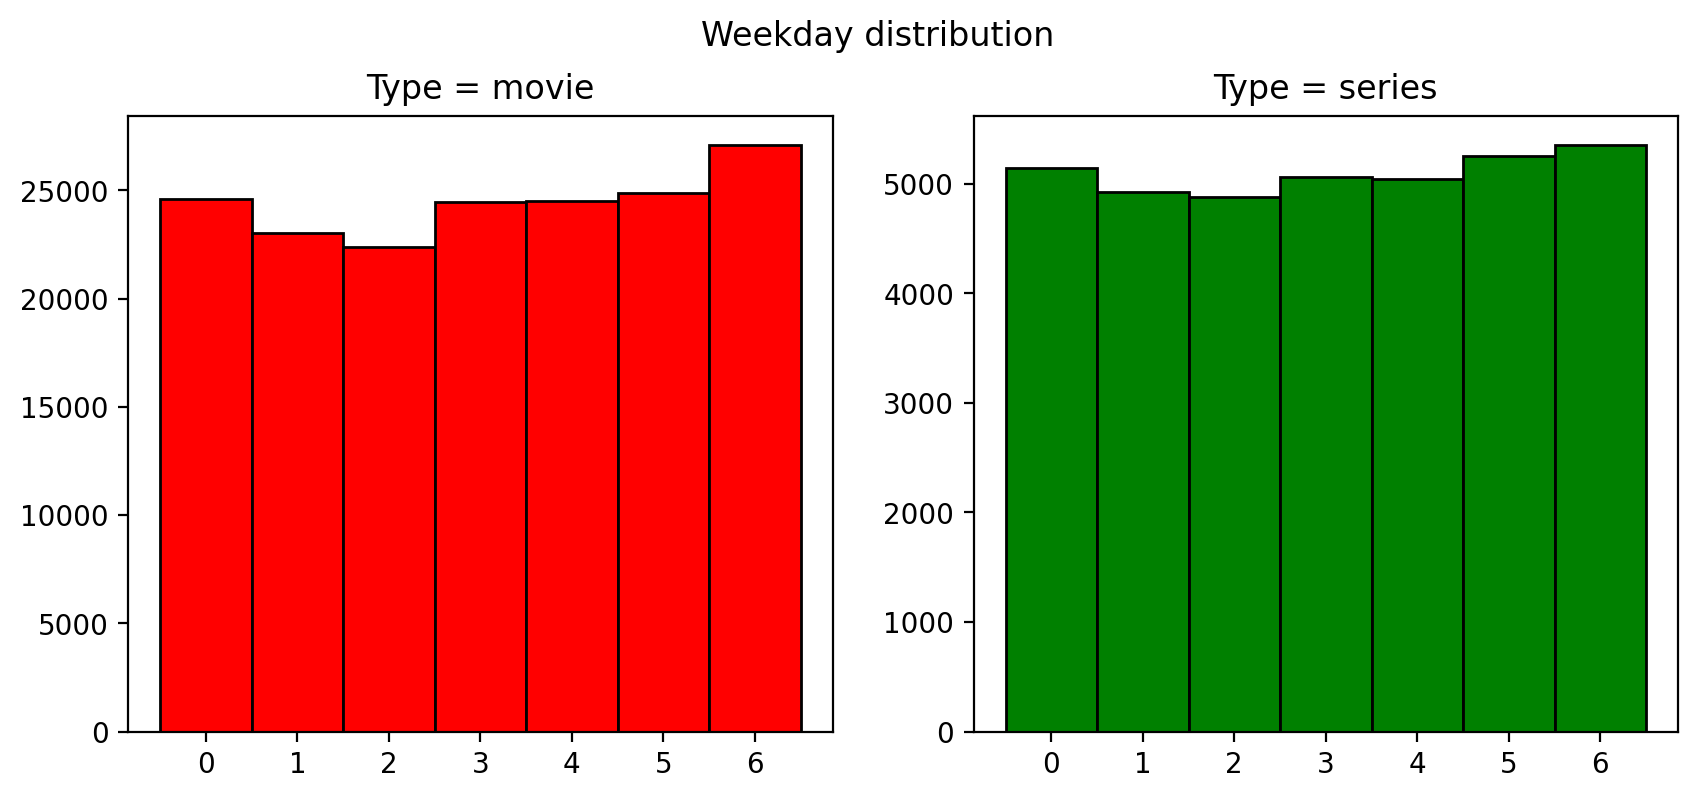

In [22]:
plot_dt_per_type(
    dataframe=reviews,
    column="weekday",
    title="Weekday distribution",
    bins=7,
    figsize=(10, 4),
)

People tend to publish more reviews on Sundays, but between Mondays, Thursdays, Fridays and Saturdays the difference is not that significant

##### Month distribution

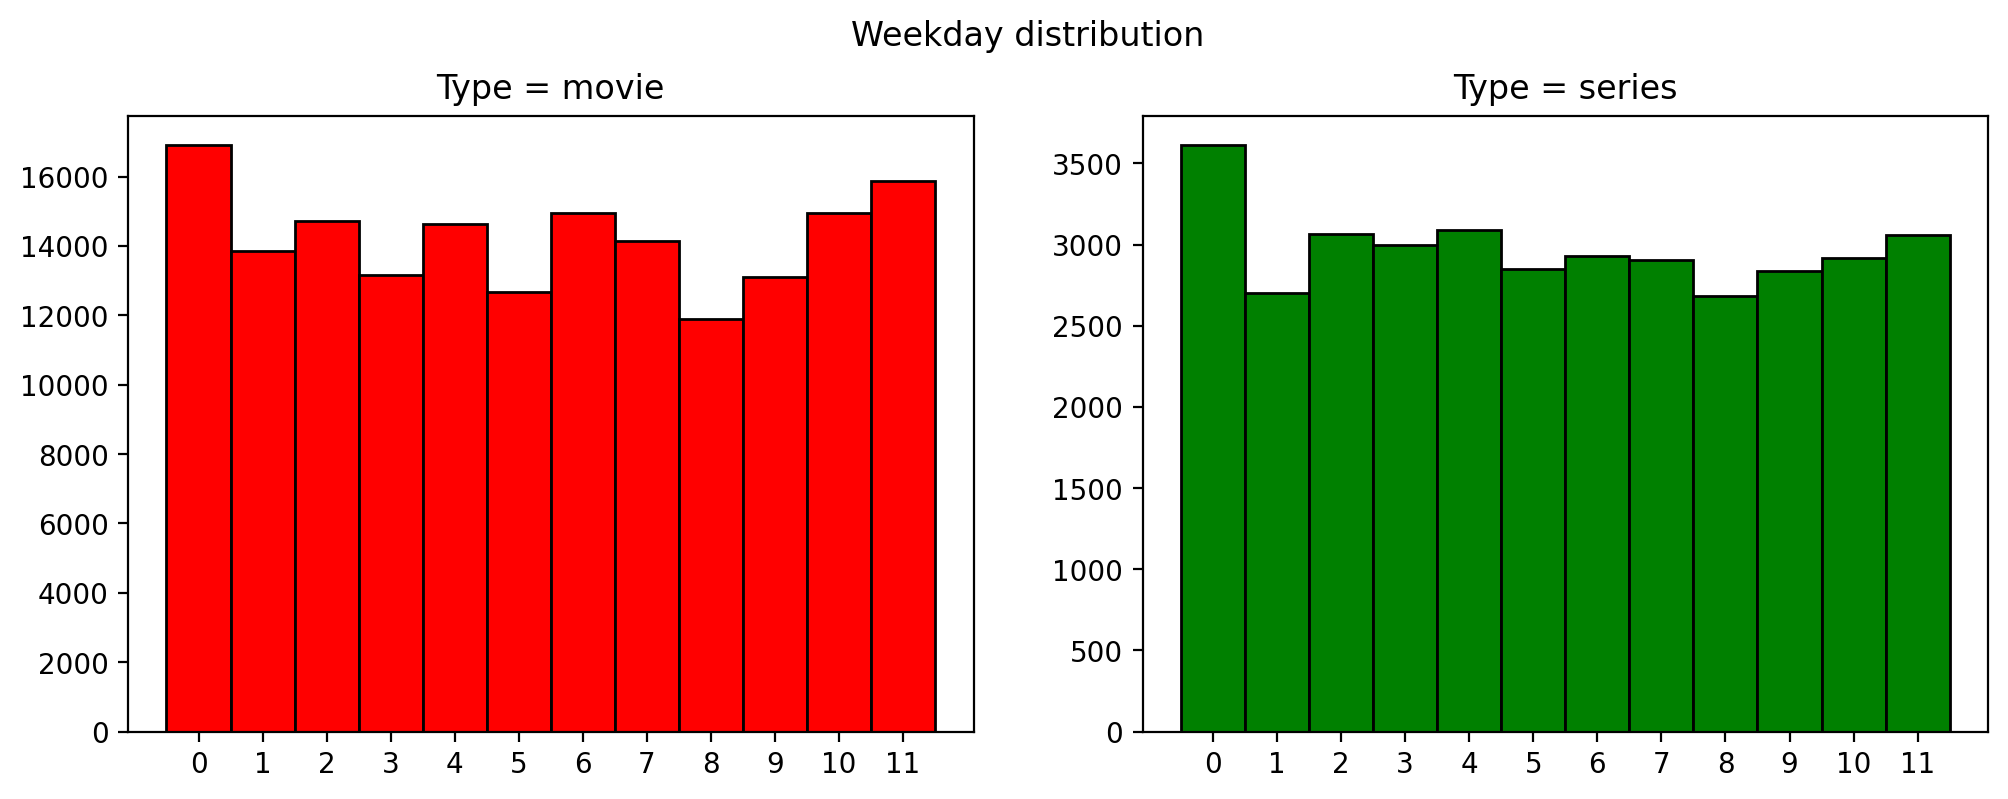

In [23]:
plot_dt_per_type(
    dataframe=reviews,
    column="month",
    title="Weekday distribution",
    bins=12,
    figsize=(12, 4),
)

People tend to publish more reviews on winter months (especially on January). It can be caused by the number of holidays in Russia in January and, also, generally correlated with cold weather.

### Subtitle

In [24]:
round(reviews["subtitle"].isna().sum() * 100 / reviews.shape[0], 2)

15.92

84% of reviews have subtitles

In [25]:
reviews["subtitle"]

0                                                      None
1                           Пересмотр в 2022 году. Ясность.
2                        Секретные материалы на максималках
3                                               Аннигиляция
4                              Дитя «Сталкера» и «Прибытия»
                                ...                        
206532                                      Нэнси уже не та
206533    И то, и это, а на выходе вместо кекса - кефир ...
206534                      Нэнси Дрю и толерантная мистика
206535                                                 None
206536                'Нэнси Дрю и Тайна преследующих тайн'
Name: subtitle, Length: 206537, dtype: object

This field is not very interesting, so we are not going to analyze it further.

### Review

We will look at the distribution of tokens for reviews to estimate the average length of review for sentiment classification in the future.

#### Preparation

In [26]:
reviews["review"] = reviews["review"].str.replace("<p>", " ")

In [34]:
pipeline = InferencePipeline(
    texts=reviews["review"].values.tolist(),
    class_labels=reviews["sentiment"].values.tolist(),
    max_length=None,
)

In [37]:
tokens = []
for texts_batch, _ in tqdm(
    pipeline.generate_batches(pipeline.texts, pipeline.class_labels),
    total=pipeline.num_batches,
    unit="batch",
):
    tokens.extend(
        pipeline.tokenizer.tokenize(texts_batch)["input_ids"]
    )

  0%|          | 0/1230 [00:00<?, ?batch/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [44]:
reviews["number_of_tokens"] = [torch.count_nonzero(token).item() for token in tokens]

#### Analysis

In [45]:
reviews.groupby("type")["number_of_tokens"].describe(
    percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
).round()

,count,mean,std,min,1%,10%,25%,50%,75%,90%,95%,99%,99.9%,max
type,,,,,,,,,,,,,,
movie,170894.0,506.0,292.0,2.0,75.0,203.0,295.0,439.0,651.0,918.0,1114.0,1388.0,1521.0,4770.0
series,35643.0,505.0,299.0,2.0,73.0,197.0,287.0,432.0,649.0,936.0,1148.0,1395.0,1525.0,2234.0


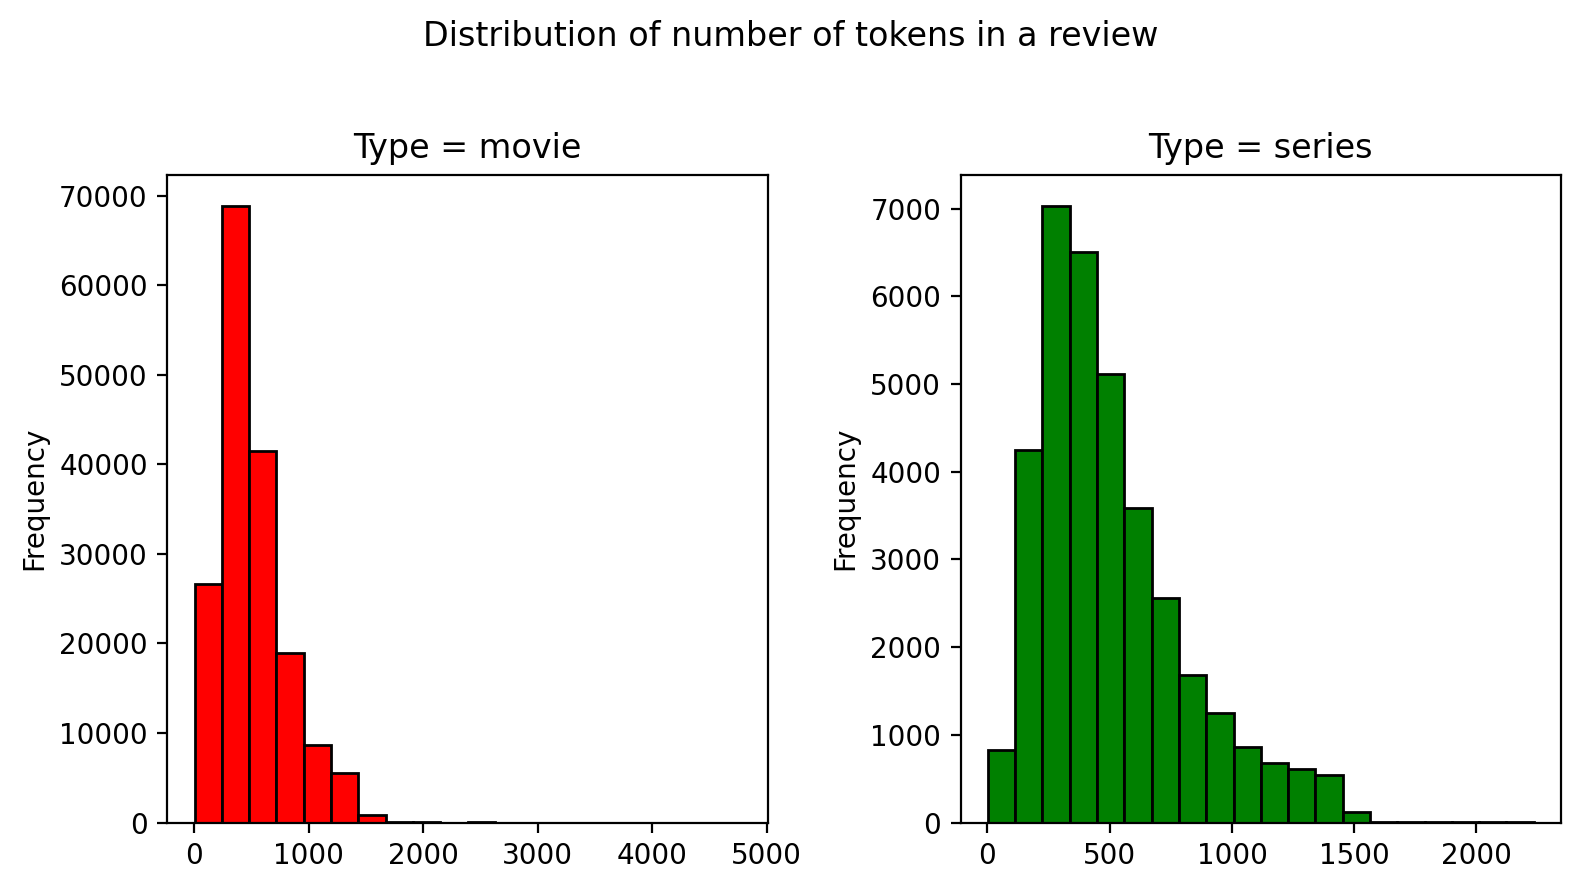

In [46]:
plot_per_type(
    dataframe=reviews,
    column="number_of_tokens",
    title="Distribution of number of tokens in a review",
    bins=20,
)

As we can see, some reviews are longer than 512 tokens, which is not good, because usually BERT-like architectures have a max length limit of tokens equal to 512. 

Basically, we have two options in the future:

 - Cut the longer texts off and only use the first/last 512 tokens. The original BERT implementation (and probably the others as well) truncates longer sequences automatically. For most cases, this option is sufficient.
 - Split reviews in multiple subtexts, classify each of them and combine the results back together (choose the class which was predicted for most of the subtexts for example). This option is obviously more expensive.

### Review score

On this online platform users are allowed to leave feedback for others reviews. 
They can either up-vote or down-vote a review.

In [47]:
reviews["review_score"].describe(
    percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
).round(1)

count    206537.0
mean          3.8
std          67.7
min       -9332.0
1%         -149.0
10%         -11.0
25%          -1.0
50%           4.0
75%          12.0
90%          26.0
95%          41.0
99%         112.0
99.9%       428.0
max        4921.0
Name: review_score, dtype: float64

In [48]:
reviews.groupby("type")["review_score"].describe(
    percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]
).round(1)

,count,mean,std,min,1%,10%,25%,50%,75%,90%,95%,99%,99.9%,max
type,,,,,,,,,,,,,,
movie,170894.0,3.3,62.8,-9332.0,-138.0,-11.0,-1.0,3.0,11.0,22.0,35.0,102.0,402.1,4921.0
series,35643.0,6.3,87.8,-4820.0,-222.0,-15.0,0.0,7.0,21.0,42.0,61.0,150.0,506.1,1960.0


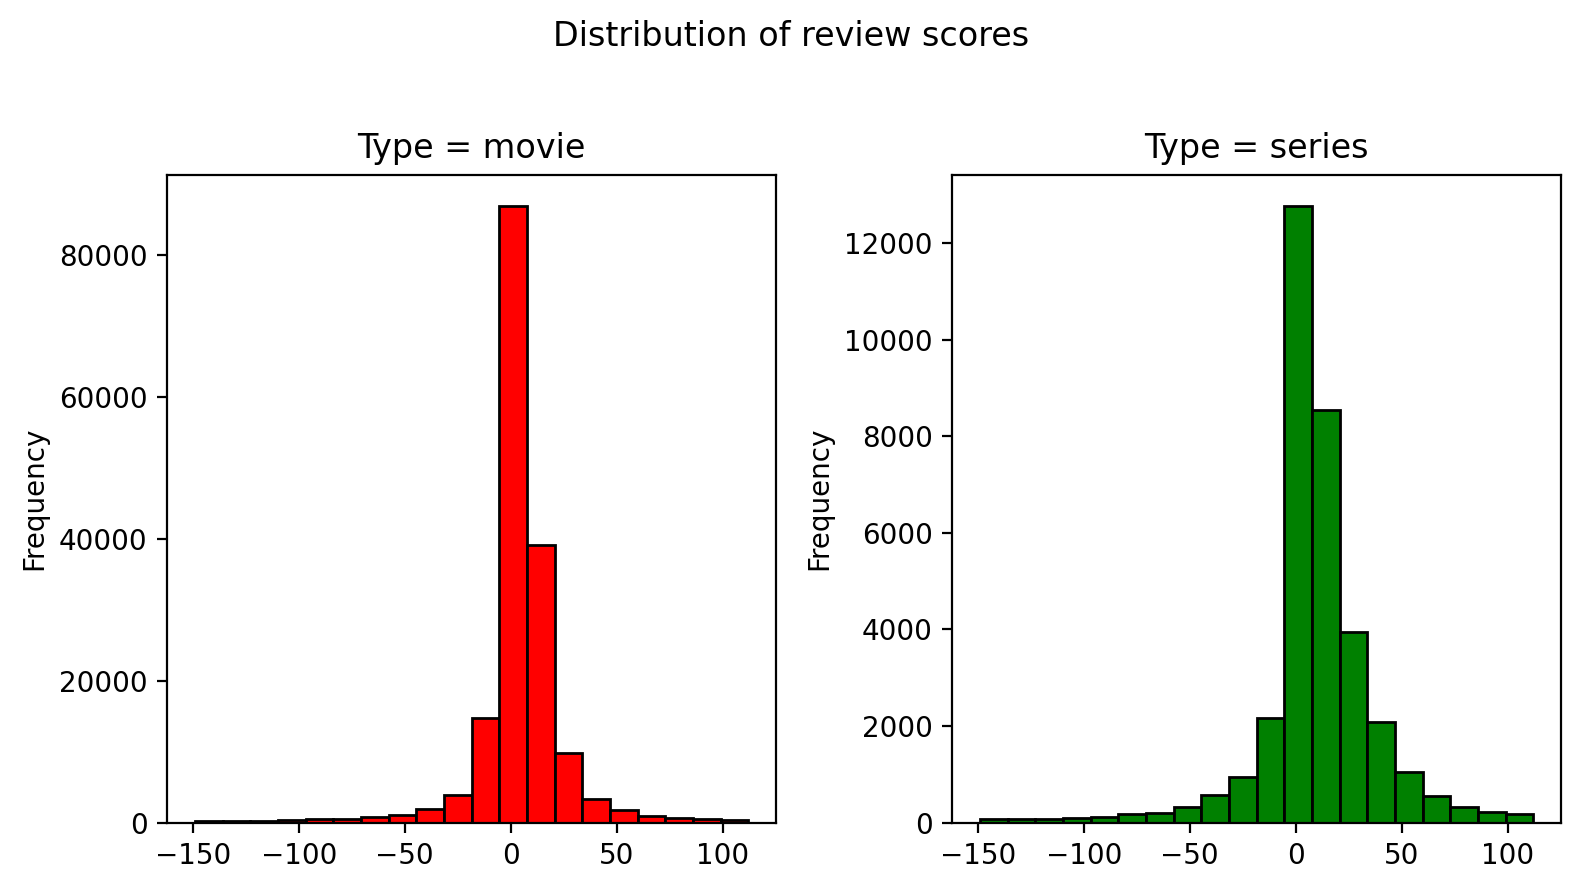

In [49]:
plot_per_type(
    dataframe=reviews[
        (reviews["review_score"] >= -149) & (reviews["review_score"] <= 112)
    ],
    column="review_score",
    title="Distribution of review scores",
    bins=20,
)

As we can see, there are a lot of reviews which are neither positively nor negatively rated by users.  
Overall, more reviews are positively rated, but some reviews are so wrong - they have a very low user's score.

### Score

Last, but not least, we have a score, which I've extracted from the reviews before this analysis.  
Approximately 64% of reviews have such score.

In [50]:
100 - round(reviews["score"].isna().sum() * 100 / reviews.shape[0], 2)

62.56

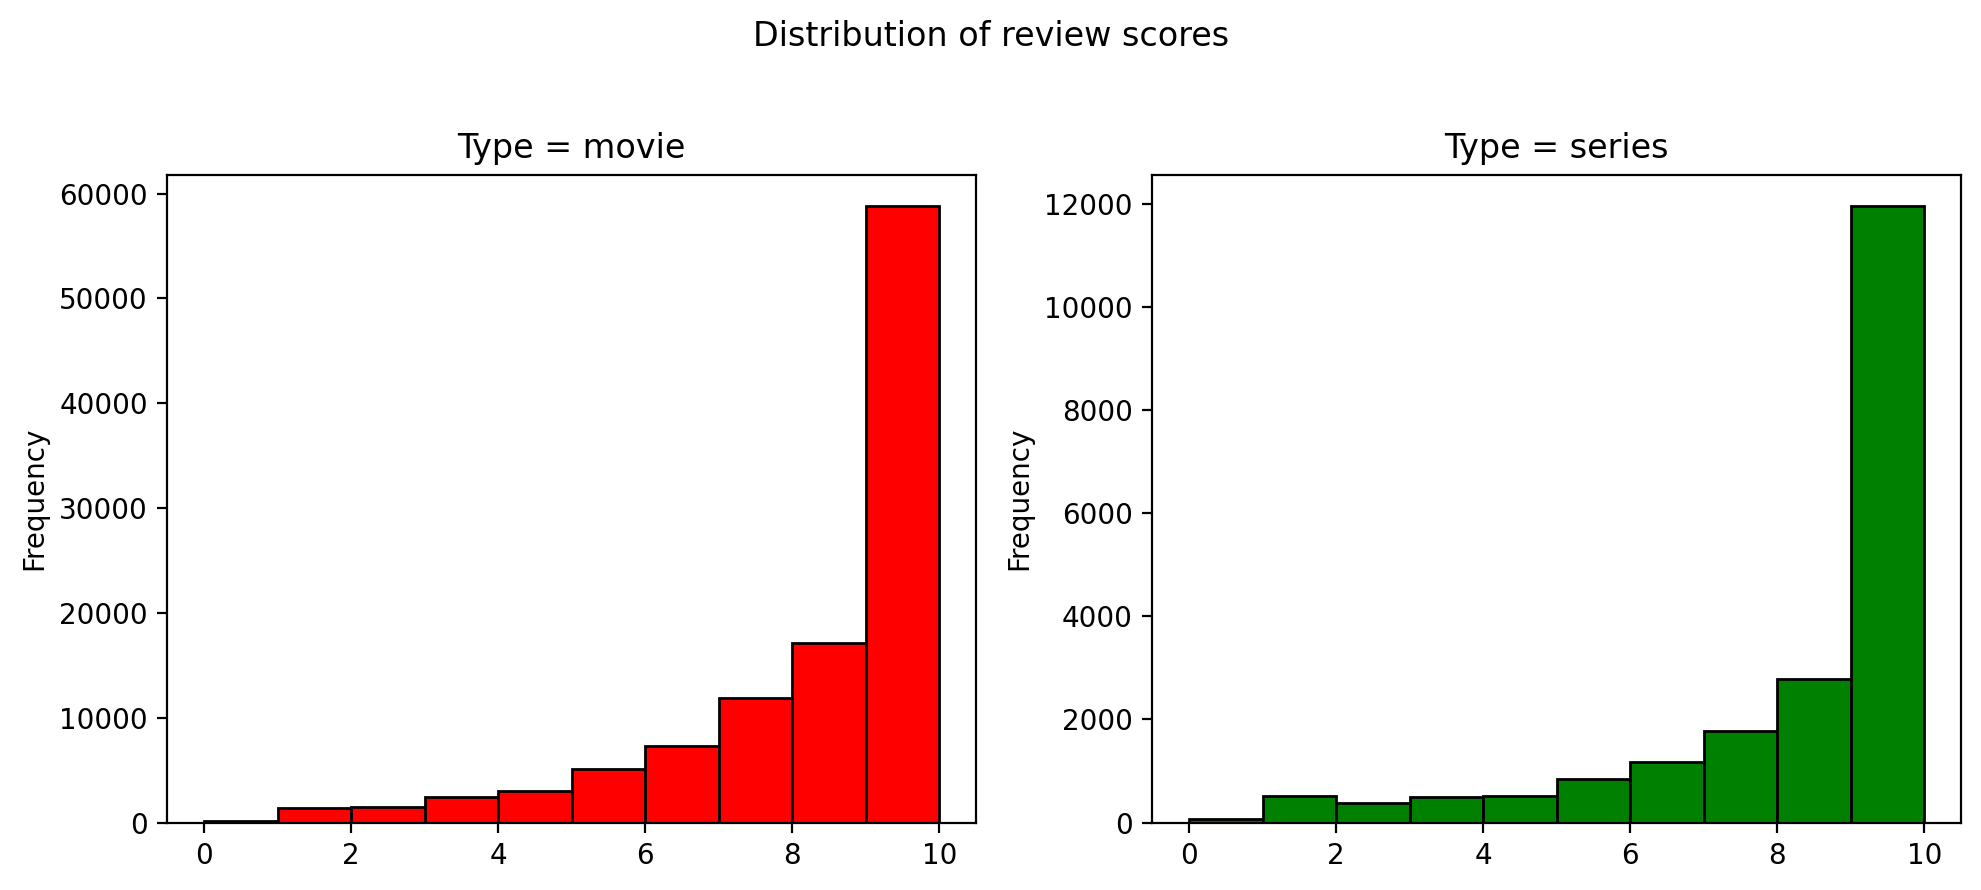

In [51]:
plot_per_type(
    dataframe=reviews,
    column="score",
    title="Distribution of review scores",
    bins=10,
    figsize=(10, 4),
)

As expected, people tend to leave high scores (me too, personally), because they either like the movie or not.

### Interactions

#### Score and Sentiment

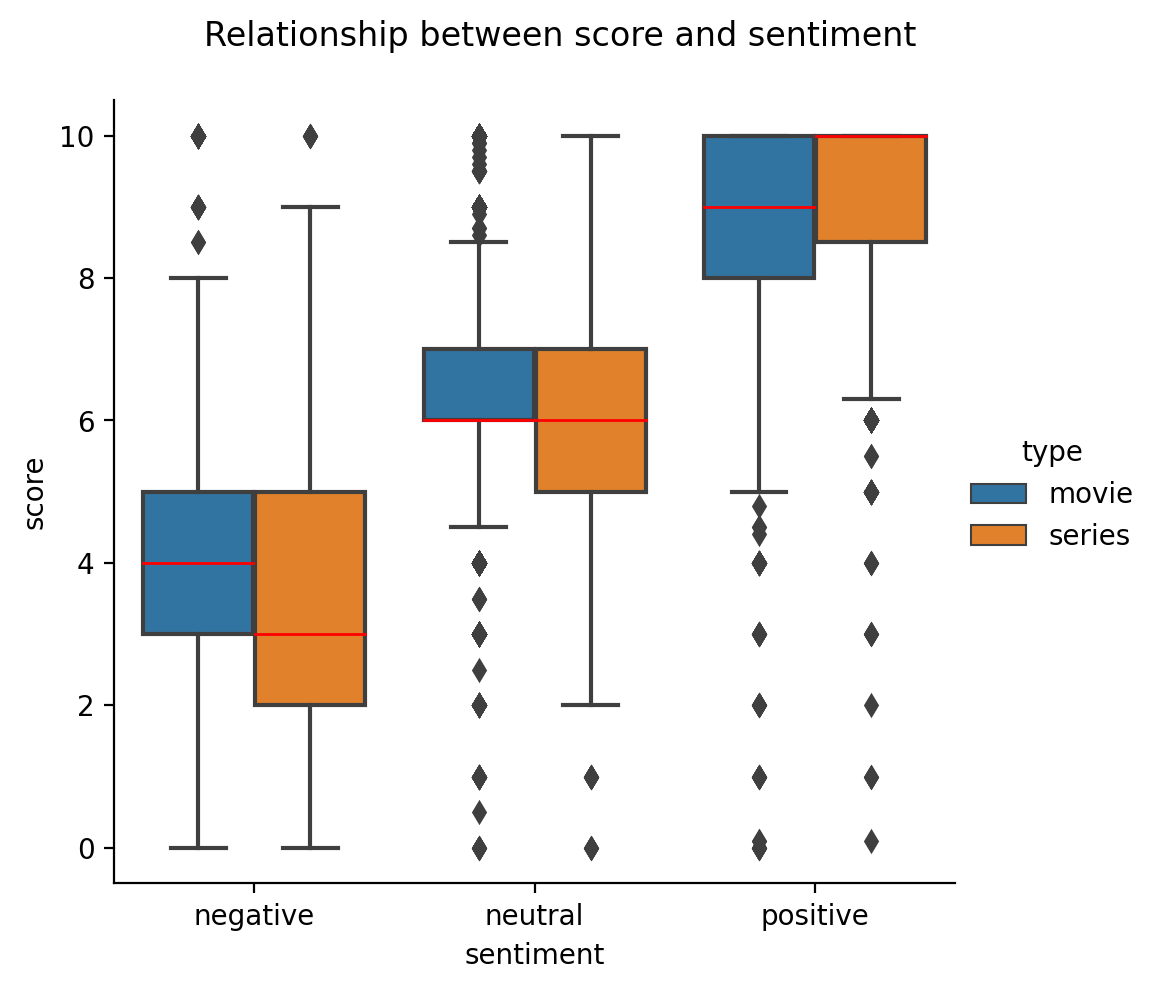

In [52]:
plot_catplot(
    y="score",
    x="sentiment",
    hue="type",
    data=reviews,
    title="Relationship between score and sentiment",
)

Clearly, `score` is a very good feature.  
The median `score` of negative reviews is very low (4 for movies and 3 for series). For neutral reviews the median `score` is higher (6). Positive reviews have the highest median `score` (9 for movies and 10 for series).  
That is why I've extracted scores from the reviews (where it was possible) - I don't want them to influence the classifier. 

#### Number of tokens in review and Sentiment

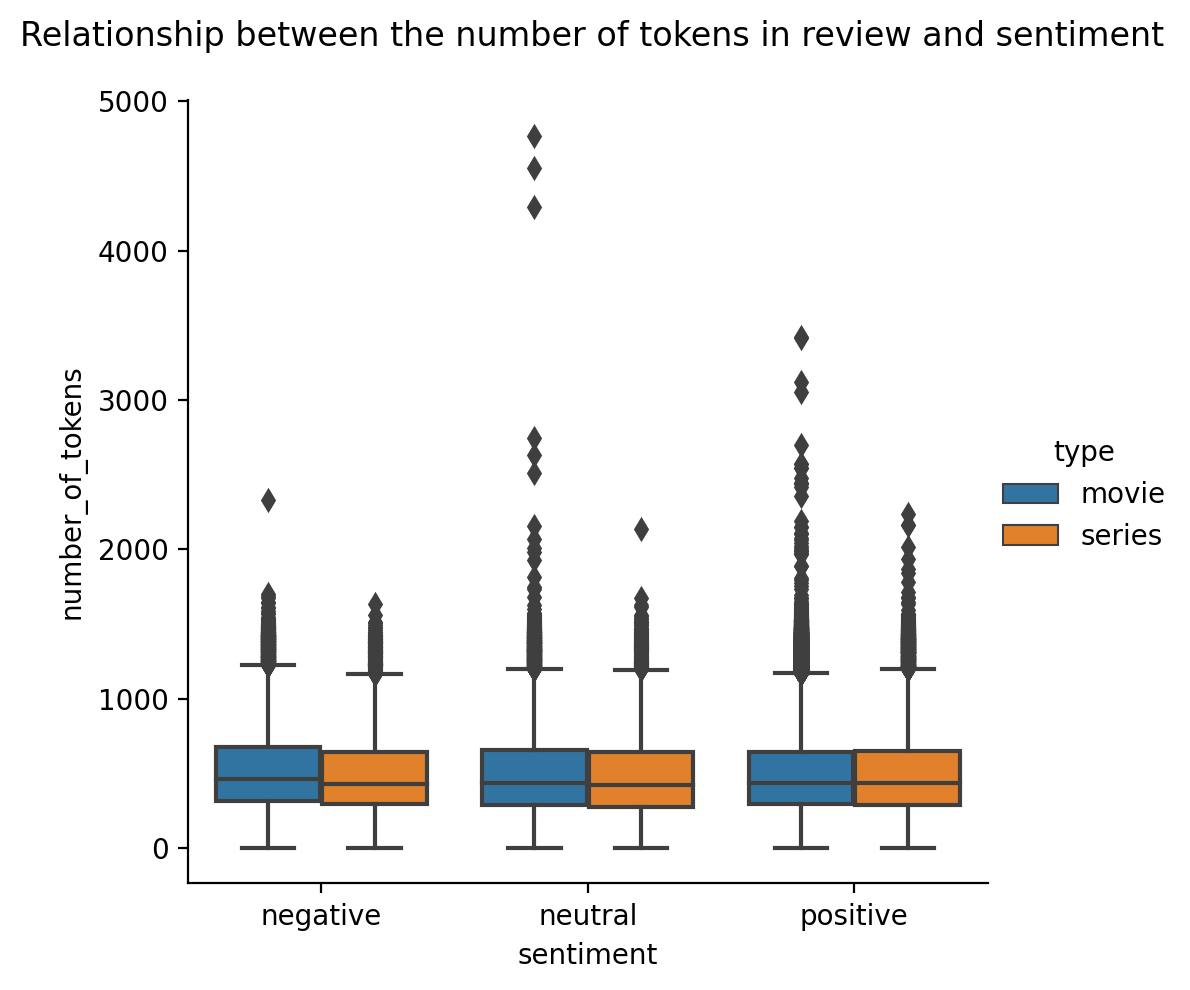

In [53]:
plot_catplot(
    y="number_of_tokens",
    x="sentiment",
    hue="type",
    data=reviews,
    medianprops={},
    title="Relationship between the number of tokens in review and sentiment",
)

As we can see from the plot, the number of tokens (length of the review) is the same for different sentiment of the review. So, using the length of the review directly as a feature is not an option - it will be useless. 